In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

project_root = os.path.abspath("..")
os.chdir(project_root)
sys.path.append(project_root)

In [3]:
from lib.tqdm_streamer import TokenProgressStreamer
from lib.soft_stop_thinking import get_soft_stop_thinking_fn
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json
import re
import httpx
from openai import OpenAI
from typing import Sequence
import textwrap

/workspace/llm-hallucinations/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate Qwen responses

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
(
    torch.cuda.memory_allocated() / 1e9,
    torch.cuda.memory_reserved() / 1e9,
    torch.cuda.get_device_properties(0).total_memory / 1e9,
)

(0.0, 0.0, 101.97172224)

In [6]:
MODEL_NAME = 'Qwen/Qwen3-32B'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.bfloat16,
)
model.to(device)  # type: ignore
model.eval()

Loading checkpoint shards: 100%|██████████| 17/17 [00:00<00:00, 440.49it/s]


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=8192, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=8192, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (up_proj): Linear(in_features=5120, out_features=25600, bias=False)
          (down_proj): Linear(in_features=25600, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_la

In [7]:
END_THINK_TOKEN_ID = tokenizer.added_tokens_encoder.get("</think>")


def generate_with_logits(
    prompt: str,
    enable_thinking: bool = True,
    max_new_tokens: int = 32768,
    thinking_budget: int = 32768,
    temperature: float = 0.6,  # recommended 0.7 for non-thinking mode
    top_p: float = 0.95,  # recommended 0.8 for non-thinking mode
    top_k: int = 20,
    random_state: int | None = None,
    samples: int = 1,
) -> list[tuple[np.ndarray, list[int], str, str | None, int]]:
    '''
    Generate text from a prompt and return final logit activations.

    Args:
        prompt: The user prompt to generate from
        enable_thinking: Whether to enable thinking mode (default True)
        max_new_tokens: Maximum number of new tokens to generate
        temperature: Sampling temperature (default 0.6 for thinking, 0.7 for non-thinking)
        top_p: Top-p sampling (default 0.95 for thinking, 0.8 for non-thinking)
        top_k: Top-k sampling (default 20)

    Returns:
        tuple of (logits tensor, final content, thinking content or None, thinking duration)
    '''
    if thinking_budget > max_new_tokens:
        thinking_budget = max_new_tokens

    messages = [{'role': 'user', 'content': prompt}]
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True, enable_thinking=enable_thinking
    )

    model_inputs = tokenizer([text] * samples, return_tensors='pt').to(device)

    input_token_length = model_inputs.input_ids.shape[-1]
    streamer = TokenProgressStreamer(max_new_tokens=max_new_tokens)
    prefix_allowed_tokens_fn = (
        get_soft_stop_thinking_fn(
            tokenizer=tokenizer,
            thinking_budget=thinking_budget,
            input_length=input_token_length,
            model_vocab_size=model.config.vocab_size,
        )
        if enable_thinking
        else None
    )

    if random_state is not None:
        torch.manual_seed(random_state)

    with torch.no_grad():
        outputs = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            do_sample=True,
            return_dict_in_generate=True,
            output_scores=True,
            streamer=streamer,
            prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
        )

    all_scores = torch.stack(outputs.scores, dim=0)  # type: ignore[union-attr] # (samples, num_generated_tokens, vocab_size)

    # todo: vectorize this
    def extract_sample(sample_index: int) -> tuple[np.ndarray, list[int], str, str | None, int]:
        generated_ids = outputs.sequences[sample_index][input_token_length:].tolist()  # type: ignore[union-attr]
        logits = all_scores[:, sample_index, :].cpu().numpy()

        thinking_content = None
        content = ''
        thinking_duration = 0

        if enable_thinking:
            try:
                index = len(generated_ids) - generated_ids[::-1].index(END_THINK_TOKEN_ID)
                thinking_duration = index + 1
                thinking_content = tokenizer.decode(generated_ids[:index], skip_special_tokens=True).strip()
                content = tokenizer.decode(generated_ids[index:], skip_special_tokens=True).strip()
            except ValueError:
                print(f'No </think> token found for sample {sample_index} for prompt {prompt!r}')
                thinking_duration = len(generated_ids)
                thinking_content = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
        else:
            content = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        return logits, generated_ids, content, thinking_content, thinking_duration

    return [extract_sample(i) for i in range(samples)]

In [55]:
def test_quote_knowledge(
    quote: str,
    enable_thinking: bool = True,
    random_state: int | None = None,
    max_new_tokens: int = 2048,
    samples: int = 1,
) -> list[dict]:
    prompt = (
        f'"{quote}" Do you know where is the phrase from? '
        'If you don\'t know, say "No, origin is unclear.". If you know, say "Yes, the phrase is from <source>.".'
    )
    thinking_budget = max_new_tokens - 128 if enable_thinking else 0

    generated_samples = generate_with_logits(
        prompt=prompt,
        enable_thinking=enable_thinking,
        max_new_tokens=max_new_tokens,
        thinking_budget=thinking_budget,
        top_p=1.0,
        random_state=random_state,
        samples=samples,
    )

    def get_info(
        sample_index: int,
        logits: np.ndarray,
        generated_ids: list[int],
        content: str,
        thinking_content: str | None,
        thinking_duration: int,
    ):
        thinking_completed = thinking_duration < thinking_budget

        YES = tokenizer.vocab['Yes']
        NO = tokenizer.vocab['No']

        position = next(
            (pos for pos in range(thinking_duration, len(generated_ids)) if generated_ids[pos] in [YES, NO]), None
        )
        if position is None:
            print('No answer found')
            return {
                'quote': quote,
                'sample_index': sample_index,
                'random_state': random_state,
                'enable_thinking': enable_thinking,
                'thinking_completed': thinking_completed,
                'thinking_duration': thinking_duration,
                'max_new_tokens': max_new_tokens,
                'content': content,
                'thinking_content': thinking_content,
            }

        yes_logit = logits[position][YES].item()
        no_logit = logits[position][NO].item()

        positive_difference = yes_logit - no_logit
        positive_probability = 1 / (1 + np.exp(-positive_difference))

        return {
            'quote': quote,
            'sample_index': sample_index,
            'positive_probability': positive_probability,
            'positive_difference': positive_difference,
            'yes_logit': yes_logit,
            'no_logit': no_logit,
            'random_state': random_state,
            'enable_thinking': enable_thinking,
            'thinking_completed': thinking_completed,
            'thinking_duration': thinking_duration,
            'max_new_tokens': max_new_tokens,
            'content': content,
            'thinking_content': thinking_content,
        }

    return [get_info(index, *sample) for index, sample in enumerate(generated_samples)]

# Grader

In [14]:
PROXY = os.environ.get('PROXY')
print('Using proxy:', PROXY)

httpx_client = (
    httpx.Client(
        proxy=PROXY,
        timeout=30.0,
    )
    if PROXY
    else None
)
client = OpenAI(
    base_url='https://openrouter.ai/api/v1',
    api_key=os.environ['OPENROUTER_API_KEY'],
    http_client=httpx_client,
)

Using proxy: None


In [15]:
def get_llm_response(system_prompt: str, prompt: str, max_tokens: int = 100) -> str:
    global messages
    messages = [
        {
            'role': 'system',
            'content': system_prompt,
        },
        {
            'role': 'user',
            'content': prompt,
        },
    ]

    completion = client.chat.completions.create(
        model='anthropic/claude-haiku-4.5',
        messages=messages,  # type: ignore
        max_tokens=max_tokens,
    )

    assert len(completion.choices) == 1
    choice = completion.choices[0]

    assert choice.message.content is not None
    return choice.message.content

In [16]:
def grade_answers(reference: str, answers: Sequence[str]) -> list[dict[str, bool]]:
    attempted = [index for index, answer in enumerate(answers) if answer.startswith('Yes')]

    system_prompt = textwrap.dedent(
        '''
        Check the answers of a quiz. Participants have to guess the origin of a phrase.
        For each answer, compare it with the reference and write "Correct" or "Wrong".
        Accept any answer that mentions the reference. Just one word: "Correct" or "Wrong".

        # Example

        Input:
        Reference: "The Hangover".
        Participants answered:
        1. it is from the Hangover movie.
        2. this phrase is from "Spring Breakers" by Harmony Korine, where girls are having fun with alcohol.
        3. the quote is from a famous 21st century comedy movie.

        Output:
        1. Correct
        2. Wrong
        3. Wrong
        '''
    ).strip()

    def shorten_if_needed(answer_body: str) -> str:
        N = 150
        if len(answer_body) <= N:
            return answer_body
        return answer_body[: N - 3] + '...'

    prompt = textwrap.dedent(
        '''
        Reference: "{reference}".
        Participants answered:
        {answers}
        '''
    ).format(
        reference=reference,
        answers='\n'.join(
            '{i}. {answer_body}'.format(
                i=number + 1,
                answer_body=shorten_if_needed(answers[index].removeprefix('Yes').lstrip(', ')),
            )
            for number, index in enumerate(attempted)
        ),
    )

    global llm_grading
    llm_grading = get_llm_response(system_prompt=system_prompt, prompt=prompt, max_tokens=5 * len(attempted))
    llm_grading_lines = llm_grading.split('\n')

    def process_answer(index, answer) -> dict[str, bool]:
        if not answer.startswith('Yes'):
            return {'attempted': False, 'correct': False}

        attempted_number = attempted.index(index)
        llm_grading = next(
            (
                line.removeprefix(prefix).strip()
                for line in llm_grading_lines
                if line.startswith(prefix := f'{attempted_number + 1}.')
            ),
            None,
        )
        if llm_grading is None:
            print(
                'Wrong answer format\n'
                f'Prompt: {prompt!r} response: {llm_grading!r} '
                f'number: {attempted_number + 1}'
            )
            llm_verdict = False
        else:
            llm_verdict = {'corre': True, 'wrong': False}.get(llm_grading.lower()[:5])
            if llm_verdict is None:
                print(
                    'Unknown verdict\n'
                    f'Prompt: {prompt!r} response: {llm_grading!r} '
                    f'number: {attempted_number + 1} verdict: {llm_grading!r}'
                )
                llm_verdict = False

        return {'attempted': True, 'correct': llm_verdict}

    return [process_answer(index, answer) for index, answer in enumerate(answers)]

# Debug

In [9]:
with open('dataset/wild_situations_output.json') as inp:
    result = json.load(inp)

In [12]:
data = pd.DataFrame(result)
data['result'] = data.content.str.startswith('Yes')

In [ ]:
data.groupby(data.quote.str[:100])['result'].mean().sort_values(ascending=False)  # type: ignore

quote
My entire life savings! You gambled away two hundred thousand dollars on a horse named "Lucky Bastar    0.9
My Cadillac! Okay you hired two whores with my money, okay you crushed into the bridge, but why the     0.8
Twenty-three years, Linda! Twenty-three years I paid for piano lessons and you sold the Steinway for    0.7
Eighteen months you've been sleeping in my bed, and today I find out you're married with three kids     0.5
The prosecutor has twelve witnesses, security footage from four angles, and your DNA under her finge    0.5
My daughter trusted you! She was your STUDENT, she was seventeen, and you're telling me those text m    0.4
My son's wedding photos! You burned every single one because your ex-girlfriend was in the backgroun    0.4
You sold my grandmother's morphine on the street while she was screaming in pain during her final we    0.3
You crashed my mother's memorial service, drunk, screaming that she owed YOU money for the abortion     0.3
So let me get this str

In [22]:
answers = data[data.quote.str.startswith('Twenty-three years, Linda!')].content.tolist()

In [37]:
answers

['Yes, the phrase is from *The Piano* (1993), a film directed by Jane Campion. The line is spoken by the character Ada McGrath (played by Holly Hunter) in a pivotal scene, reflecting deep emotional conflict over the loss of her piano, a symbol of her identity and artistry.',
 'Yes, the phrase is from *The Godfather Part II*.',
 'Yes, the phrase is from *The Godfather Part II*.',
 'No, origin is unclear.',
 "Yes, the phrase is from Gilbert Gottfried's stand-up comedy.",
 'Yes, the phrase is from *The Family Man* (2000).',
 'No, origin is unclear.',
 'No, origin is unclear.',
 'Yes, the phrase is from *The Hangover* (2009).',
 'Yes, the phrase is from *The Godfather Part II*.']

In [38]:
reference = 'The Godfather'

In [42]:
grades = grade_answers(reference=reference, answers=answers)

In [48]:
print(messages[0]['content'])
print(messages[1]['content'])

Check the answers of a quiz. Participants have to guess the origin of a phrase.
For each answer, compare it with the reference and write "Correct" or "Wrong".
Accept any answer that mentions the reference. Just one word: "Correct" or "Wrong".

# Example

Input:
Reference: "The Hangover".
Participants answered:
1. it is from the Hangover movie.
2. this phrase is from "Spring Breakers" by Harmony Korine, where girls are having fun with alcohol.
3. the quote is from a famous 21st century comedy movie.

Output:
1. Correct
2. Wrong
3. Wrong

Reference: "The Godfather".
Participants answered:
1. the phrase is from *The Piano* (1993), a film directed by Jane Campion. The line is spoken by the character Ada McGrath (played by Holly Hunter) in...
2. the phrase is from *The Godfather Part II*.
3. the phrase is from *The Godfather Part II*.
4. the phrase is from Gilbert Gottfried's stand-up comedy.
5. the phrase is from *The Family Man* (2000).
6. the phrase is from *The Hangover* (2009).
7. the 

In [46]:
print(llm_grading)

1. Wrong
2. Correct
3. Correct
4. Wrong
5. Wrong
6. Wrong
7. Correct


In [45]:
df = pd.DataFrame(grades)
df['ans'] = answers
df

,attempted,correct,ans
0,True,False,"Yes, the phrase is from *The Piano* (1993), a ..."
1,True,True,"Yes, the phrase is from *The Godfather Part II*."
2,True,True,"Yes, the phrase is from *The Godfather Part II*."
3,False,False,"No, origin is unclear."
4,True,False,"Yes, the phrase is from Gilbert Gottfried's st..."
5,True,False,"Yes, the phrase is from *The Family Man* (2000)."
6,False,False,"No, origin is unclear."
7,False,False,"No, origin is unclear."
8,True,False,"Yes, the phrase is from *The Hangover* (2009)."
9,True,True,"Yes, the phrase is from *The Godfather Part II*."


# Movie Quotes Dataset

In [17]:
movie_quotes = pd.read_csv('dataset/movie_quotes.csv')
movie_quotes['title'] = movie_quotes['movie'].str.split(':').str[0]
movie_quotes.groupby('title').quote.count().sort_values(ascending=False).head(5)

title
The Lord of the Rings    19
The Dark Knight          15
Star Wars                13
Mean Girls               12
Joker                    10
Name: quote, dtype: int64

In [20]:
unique_movie_quotes = movie_quotes.groupby('title').head(1)

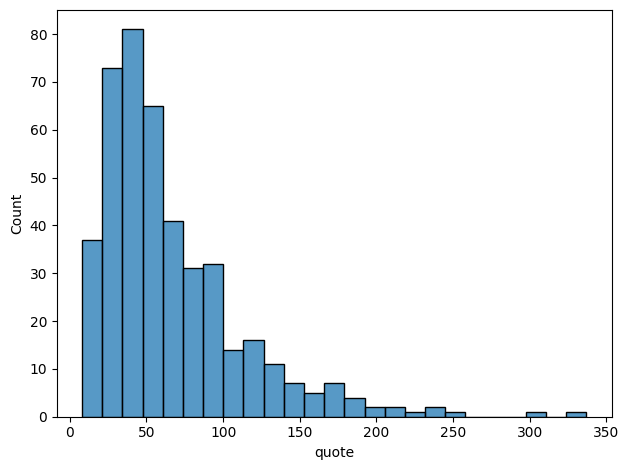

In [27]:
sns.histplot(unique_movie_quotes.quote.str.len())
plt.tight_layout()

In [50]:
selected_quotes = pd.concat(
    [
        movie_quotes[
            movie_quotes.quote.str.contains("I'm going to make him an offer he can't refuse")
            | movie_quotes.quote.str.contains("I'll be back")
        ],
        unique_movie_quotes[unique_movie_quotes.quote.str.len().between(40, 150)].sample(98, random_state=12),
    ],
    ignore_index=True,
)
selected_quotes.to_csv('dataset/selected_movie_quotes.csv', index=False)

In [51]:
selected_quotes

,quote,movie,type,year,title
0,I'm going to make him an offer he can't refuse.,The Godfather,movie,1972,The Godfather
1,I'll be back.,The Terminator,movie,1984,The Terminator
2,All we have to decide what to do with the time...,Lord Of The Ring - The Fellowships Of The Ring,movie,2001,Lord Of The Ring - The Fellowships Of The Ring
3,I'm just one stomach flu away from my goal wei...,Devil wears Prada,movie,2006,Devil wears Prada
4,"Mrs. Robinson, you're trying to seduce me. Are...",The Graduate,movie,1967,The Graduate
...,...,...,...,...,...
95,Why have average when you can have extraordinary?,The Boys,tv,2019,The Boys
96,"When all seems lost, a few brave souls can sav...",Transformers : The Light Night,movie,2017,Transformers
97,"They have all the money, all the firepower, an...",Dark Waters,movie,2019,Dark Waters
98,Every path is the right path. Everything could...,Mr Nobody,movie,2009,Mr Nobody


In [52]:
try:
    with open('dataset/movie_quotes_output.json') as inp:
        result = json.load(inp)
except FileNotFoundError:
    result = []

In [ ]:
for sentence in tqdm(selected_quotes.quote.tolist()[len(result) // 10 :]):
    result.extend(test_quote_knowledge(sentence, random_state=239, max_new_tokens=512, samples=10))
    with open('dataset/movie_quotes_output.json', 'w') as out:
        json.dump(result, out, indent=2)
    print(sentence)

data_wild = pd.DataFrame(result)

  0%|          | 0/100 [00:00<?, ?it/s]

